
<center><b>© 2020. Content is made available under the CC-BY-NC-ND 4.0 license. Christian Lopez, lopezbec@lafayette.edu<b><center>

**UPDATED: 11-14-2020**

<table align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/lopezbec/COVID19_XRay_Tutorial/blob/main/COVID19_Detection_from_X_Rays.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
</table>


#Training NN to predict COVID-19 from X-Ray images 

This Notebook give you a quick introduction on how to train a NN for image classification and use it to predict if a X-Ray belong to a person with COVID-19 or not.


###**Before we start:**
Make sure you are using Colab's GPU as your Hardware accelerator, go to `Runtime`>`Change runtime type`> `Run time type` > `Hardware accelerator`> `Select GPU` (this should be the defatuls of this notebook) 


Most of the notebooks we are going to be using are inspired from existing notebooks that are available online and are made free for educational purposes. Nonetheless, these notebooks should not be share without prior permission of the author.The dataset used in this notebooks is a compilation of multiple datasets found [here](https://www.kaggle.com/nabeelsajid917/covid-19-x-ray-10000-images/kernels), [here](https://www.kaggle.com/bachrr/covid-chest-xray), and [here](https://www.pyimagesearch.com/2020/03/16/detecting-covid-19-in-x-ray-images-with-keras-tensorflow-and-deep-learning/)




## 1- Setup

Google Colab already has several python libraries installed. However, there are some that we need to install. In the Code cell bellow we will import some libraries, and install other using `!pip`

In [1]:
#Common imports
import numpy as np
import pandas as pd
import os
import time
import sys
from IPython.display import clear_output
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

#Machine Learning imports
import sklearn
from sklearn.metrics import confusion_matrix
import tensorflow as tf
from tensorflow import keras
from keras import regularizers


# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")
import logging
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # FATAL
logging.getLogger('tensorflow').setLevel(logging.FATAL)

#Installing Pillow for images  
!pip install Pillow
from PIL import Image
import imageio

# GPU memory footprint support libraries/code
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
!pip install psutil
!pip install humanize
import psutil
import humanize
import os
import GPUtil as GPU
clear_output()

np.random.seed(54)

### 1.1- Lets Clone the GitHub Repo

In [2]:
!git clone https://github.com/lopezbec/COVID19_XRay_Tutorial

Cloning into 'COVID19_XRay_Tutorial'...
remote: Enumerating objects: 7, done.
remote: Counting objects: 100% (7/7), done.
remote: Compressing objects: 100% (7/7), done.
remote: Total 170 (delta 0), reused 4 (delta 0), pack-reused 163
Receiving objects: 100% (170/170), 70.96 MiB | 39.19 MiB/s, done.


Let's see tthe repot in the VM of Google Colab

In [3]:
%cd  COVID19_XRay_Tutorial  
%ls

/content/COVID19_XRay_Tutorial
COVID19_Detection_from_X-Rays.ipynb  COVID_dataset/  README.md


# 2- Load the Data

## 2.1- Lets load the X-Ray images of "nomal"/"non-COVID" patients

/content/COVID19_XRay_Tutorial/COVID_dataset/normal


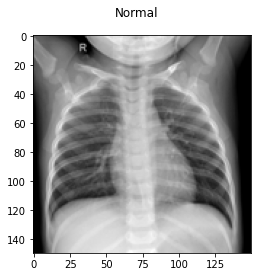

In [4]:
#Read "Nomal" X-Rays
%cd "/content/COVID19_XRay_Tutorial/COVID_dataset/normal"
list_image_names_normal=os.listdir()

normal_images = []
for name in list_image_names_normal:
    img = Image.open(name).convert('L')
    new_image = img.resize((150, 150))
    data = np.asarray(new_image, dtype="float64" )
    normal_images.append(data)

fig = plt.figure()
fig.suptitle('Normal')
plt.imshow(normal_images[0], cmap='gray') 

## 2.2- Lets load the X-Ray images of "COVID" patients

/content/COVID19_XRay_Tutorial/COVID_dataset/covid


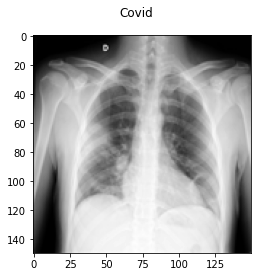

In [5]:
#Read "COVID" X-Rays
%cd "/content/COVID19_XRay_Tutorial/COVID_dataset/covid"
list_image_names_covid=os.listdir()

covid_images = []
for name in list_image_names_covid:
    img = Image.open(name).convert('L')
    new_image = img.resize((150, 150))
    data = np.asarray(new_image, dtype="float64" )
    covid_images.append(data)

fig = plt.figure()
fig.suptitle('Covid')
plt.imshow(covid_images[1], cmap='gray') 


## 2.3- Lets explore the data to understand it

In [6]:
covid_images=np.asarray(covid_images)
normal_images=np.asarray(normal_images)
print("Size of Covid X-Rays=",covid_images.shape)
print("Size of Normal X-Rays=",normal_images.shape)

Size of Covid X-Rays= (41, 150, 150)
Size of Normal X-Rays= (132, 150, 150)


As we can see, we have more X-Rays for “Normal” patients than “COVID” (132 vs 42). This might create a data imbalance problem that we will need to address. 

Also, all the images are 150 x 150 pixels  grayscale images 



## 2.4- Let's split the dataset

Before we split the data, let "balance" our dataset, by picking the same number of class instanes (images of 'covid" and "normal")


In [7]:
random_indices = np.random.choice(normal_images.shape[0],size=covid_images.shape[0], replace=False)
normal_images=normal_images[random_indices, :]

In [8]:

X_train_full=np.vstack((normal_images,covid_images))
y_train_full=np.vstack((np.zeros((normal_images.shape[0],1)),np.ones((covid_images.shape[0],1))))
class_names = ["Normal", "Covid-19"]

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_train_full, y_train_full, test_size=0.30, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.20, random_state=18)


print("Size of Training set=",X_train.shape)
print("Size of Validaiton set=",X_val.shape)
print("Size of Testing set=",X_test.shape)

Size of Training set= (45, 150, 150)
Size of Validaiton set= (12, 150, 150)
Size of Testing set= (25, 150, 150)


Since we will be using Stocastic Gradient Descent (`sgd`) to train ouw NN, it is a good idea to scale the data.  Each pixel intensity is represented as a byte (0 to 255) since in a 8 bits we can get total number of 256 possible combinations:

In [9]:
X_train.dtype   #8-bit unsigned integer =uint8

dtype('float64')

We can scale the data by dividing it by `255`

In [10]:
X_train=X_train/255
X_val=X_val/255
X_test=X_test/255

#### 2.4.1- Training Dataset

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  # Remove the CWD from sys.path while we load stuff.


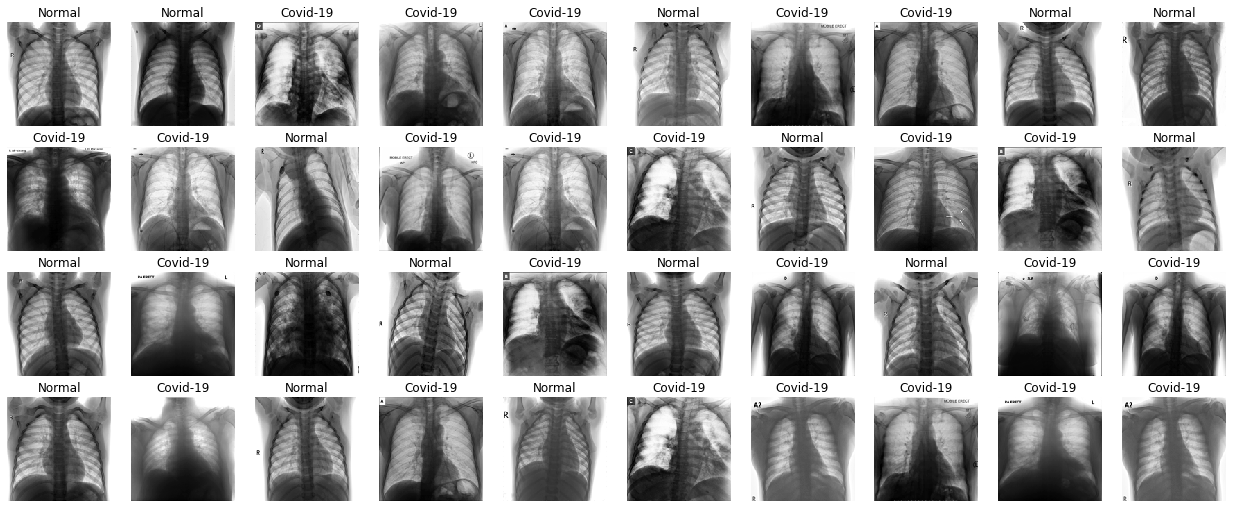

In [11]:
n_rows = 4
n_cols = 10
plt.figure(figsize=(n_cols * 2.2, n_rows * 2.2))
for row in range(n_rows):
    for col in range(n_cols):
        index = n_cols * row + col
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(X_train[index], cmap="binary", interpolation="nearest")
        plt.axis('off')
        plt.title(class_names[int(np.asscalar(y_train[index]))], fontsize=12)
plt.subplots_adjust(wspace=0.1, hspace=0.2)
plt.show()

#### 2.4.2- Validation Dataset

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  # Remove the CWD from sys.path while we load stuff.


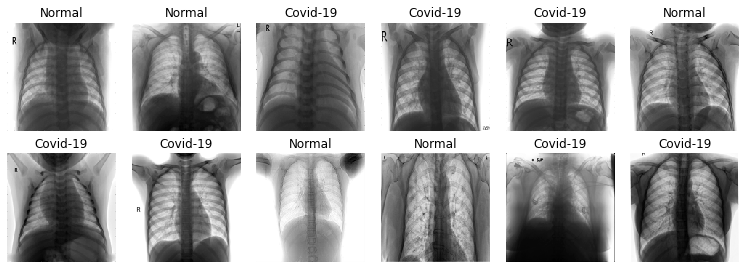

In [12]:
n_rows = 2
n_cols = 6
plt.figure(figsize=(n_cols * 2.2, n_rows * 2.2))
for row in range(n_rows):
    for col in range(n_cols):
        index = n_cols * row + col
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(X_val[index], cmap="binary", interpolation="nearest")
        plt.axis('off')
        plt.title(class_names[int(np.asscalar(y_train[index]))], fontsize=12)
plt.subplots_adjust(wspace=0.1, hspace=0.2)
plt.show()

#### 2.4.3- Testing Dataset

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  # Remove the CWD from sys.path while we load stuff.


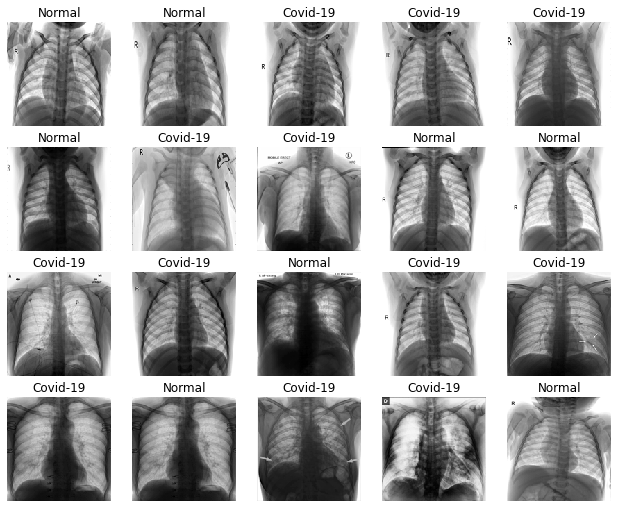

In [13]:
n_rows = 4
n_cols = 5
plt.figure(figsize=(n_cols * 2.2, n_rows * 2.2))
for row in range(n_rows):
    for col in range(n_cols):
        index = n_cols * row + col
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(X_test[index], cmap="binary", interpolation="nearest")
        plt.axis('off')
        plt.title(class_names[int(np.asscalar(y_train[index]))], fontsize=12)
plt.subplots_adjust(wspace=0.1, hspace=0.2)
plt.show()

###  

###     

# 3- Building, Training and Testing a Neural Network for Image Classification with Keras 

This Neural Network (NN) will only have one hidden layer with 100 artificial neurons. Even for this “shallow” NN, we still need to estimate more than **2 MILLION parameters**

## 3.1 - Building

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 22500)             0         
_________________________________________________________________
dense (Dense)                (None, 100)               2250100   
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
Total params: 2,250,201
Trainable params: 2,250,201
Non-trainable params: 0
_________________________________________________________________


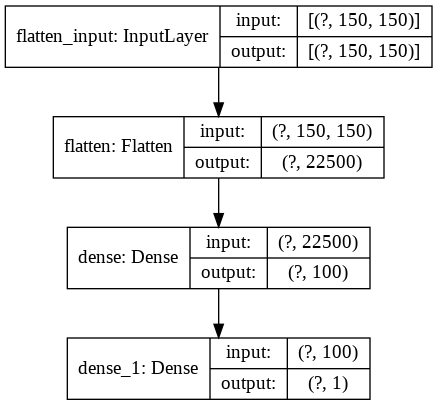

In [14]:
keras.backend.clear_session()

tf.random.set_seed(23)

# specify our Neural Network architecture
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[150, 150]),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(1, activation="sigmoid")
])

model.summary()
keras.utils.plot_model(model, show_shapes=True)

Even though we need to estimate more than 2 million parameters, because of the GPU, this take just secs

# 3.2 -Training 

Epoch 1/20
45/45 [==============================] - 0s 5ms/step - loss: 0.8606 - accuracy: 0.7111 - val_loss: 0.4339 - val_accuracy: 0.8000
Epoch 2/20
45/45 [==============================] - 0s 3ms/step - loss: 0.2846 - accuracy: 0.8444 - val_loss: 0.2243 - val_accuracy: 0.8400
Epoch 3/20
45/45 [==============================] - 0s 3ms/step - loss: 0.2228 - accuracy: 0.9333 - val_loss: 0.2603 - val_accuracy: 0.9600
Epoch 4/20
45/45 [==============================] - 0s 3ms/step - loss: 0.0635 - accuracy: 1.0000 - val_loss: 0.0493 - val_accuracy: 0.9600
Epoch 5/20
45/45 [==============================] - 0s 3ms/step - loss: 0.0198 - accuracy: 1.0000 - val_loss: 0.0262 - val_accuracy: 1.0000
Epoch 6/20
45/45 [==============================] - 0s 3ms/step - loss: 0.2988 - accuracy: 0.8889 - val_loss: 0.0460 - val_accuracy: 1.0000
Epoch 7/20
45/45 [==============================] - 0s 3ms/step - loss: 0.0185 - accuracy: 1.0000 - val_loss: 0.0961 - val_accuracy: 0.9600
Epoch 8/20
45/45 [==

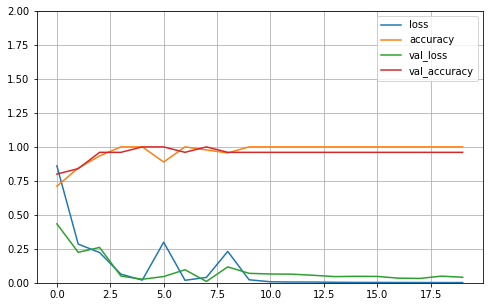

Time to train the model: 3.9464 secs 
Training Set Accuracy:   100.0000% & Loss:0.0018
Validation Set Accuracy: 96.0000% & Loss:0.0410
Test Set Accuracy:       96.0000% & Loss:0.0410


In [15]:
#Compile the  model
model.compile(loss="binary_crossentropy",
              optimizer="sgd",
              metrics=["accuracy"])

checkpoint_cb = keras.callbacks.ModelCheckpoint("my_keras_model.h5", save_best_only=True)

#Train the model
tic = time.process_time()
history_nn_f = model.fit(X_train, y_train, epochs=20, batch_size=1, validation_data=(X_test, y_test), verbose=1)
toc = time.process_time()
#Model evaluation
test_nn_f=model.evaluate(X_test, y_test, verbose=0)

#Plot performnace
pd.DataFrame(history_nn_f.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 2)
plt.show()


print("Time to train the model: {0:.4f} secs ".format((toc - tic)))
print("Training Set Accuracy:   {0:.4%} & Loss:{1:.4f}".format(history_nn_f.history['accuracy'][19],history_nn_f.history['loss'][19]))
print("Validation Set Accuracy: {0:.4%} & Loss:{1:.4f}".format(history_nn_f.history['val_accuracy'][19],history_nn_f.history['val_loss'][19]))
print("Test Set Accuracy:       {0:.4%} & Loss:{1:.4f}".format(test_nn_f[1],test_nn_f[0]))

# Testing

In [16]:
import itertools

def plot_confusion_matrix(cm, classes,
                        normalize=False,
                        title='Confusion matrix',
                        cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[14  1]
 [ 0 10]]


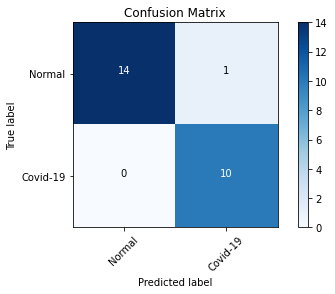

In [17]:
predIdxs = model.predict_classes(X_test, batch_size=1)
cm = confusion_matrix(y_true=y_test, y_pred=predIdxs)

plot_confusion_matrix(cm=cm, classes=class_names, title='Confusion Matrix')

This model was able to correctly classify 96% of the images on the test set, which is very good. However, we need to be aware of the limitation of this model, mainly that the dataset was not representative . However, , using Deep Convolutional Neural Network ( like https://arxiv.org/abs/2003.09871) the identification of X-rays can be significantly improved. Another limitation of this model, is that it is not identifying the aspect of the image that make it a “normal” vs “covid” image. 

This was just a quick overview of how to build, train, and test, Neural Network for Image Classification using GPUS in Google Colab and it should not be use for diagnosis 
